In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
import string
puns = string.punctuation

# Load Data

In [2]:
# df_train = pd.read_table('train.tsv')
# df_train['category_name'] = df_train['category_name'].fillna('other')
# def serialize_category(cats):
#     return cats.split('/')
# df_train['category_split'] = df_train['category_name'].apply(serialize_category)
# all_categories = list(set(np.hstack(df_train['category_split'])))
# with open('all_categories.list', 'w', encoding='utf8') as f:
#     f.write(str(all_categories))

In [7]:
with open('all_categories.list', 'r', encoding='utf8') as f:
    all_categories = eval(f.read())
print(all_categories)

['Small Animal', 'Kitchen', 'Fragrance', 'Track & Sweat Suits', 'Wallet', 'Favors', 'Quilts', 'Sticker', 'Pets', 'Skirt', 'Crewneck', 'Athletic Training', 'Luggage', 'Plate', 'Full-Length', 'Coffee & Tea Accessories', 'Turtleneck', 'Eyes', 'Dresses', 'Motorcycle', 'Dusting', 'Animals', 'Pot Holder', 'Calendars', 'Shams, Bed Skirts & Bed Frame Draperies', 'Photo Albums & Frames', 'Diapering', 'Plush', 'Storage & Organization', 'Golf', 'Golf Apparel', 'Leggings', 'Medical Supplies & Equipment', 'Books', 'Girls', 'Historical, Military', 'Waxing', 'Straight, Pencil', "Men's Accessories", 'Knitting Supplies', 'Puzzles', 'Hair Relaxers', 'Vest', 'Nail Care', 'Hiking & Camping', 'Water Sports', 'Bike & Skate', 'Gloves', 'Changing Kits', 'Monitors', 'Car Electronics & Accessories', 'Sweatshirt, Pullover', 'Trading Cards', 'TV, Audio & Surveillance', 'Jeans', 'Charm', 'Weddings', 'GPS Accessories & Mounts', 'Toddler', 'Pouch', 'Exercise', 'Pregnancy & Maternity', 'Beads', 'Face', 'Track & Field

In [4]:
# def tokenize(Doc):
#     if pd.notnull(Doc):
#         tokens = nltk.wordpunct_tokenize(Doc)
#         text = nltk.Text(tokens)
#         words = [w.lower() for w in text if w not in stops and w not in puns]
#         return words
#     else:
#         return None

# all_tokens = []
# for sent in all_categories:
#     if pd.notnull(sent):
#         all_tokens.extend(tokenize(sent))

# all_tokens = list(set(all_tokens))

# Load Word2Vec Model

In [6]:
word_vec_mapping = {}
path = "word2vec.txt"
with open(path, 'r', encoding='utf8') as f:  ## 這個文檔的格式是一行一個字並配上他的向量，以空白鍵分隔
    for line in f:  
        tokens = line.split()
        token = tokens[0]  ## 第一個token就是詞彙
        vec = tokens[1:]  ## 後面的token向量
        word_vec_mapping[token] = np.array(vec, dtype=np.float32)  ## 把整個model做成一個字典，以利查找字對應的向量
        count += 1
vec_dimensions = len(word_vec_mapping.get('men'))  ## 記錄這個mdoel每一個字的維度

In [5]:
# word_vec_mapping = {}
# # path = "D:\\word2vec\\twitter\\glove.twitter.27B.25d.txt"
# # path = "D:\\word2vec\\twitter\\glove.twitter.27B.50d.txt"
# path = "word2vec.txt"
# with open(path, 'r', encoding='utf8') as f:
#     count = 0
#     for line in f:
#         tokens = line.split()
#         token = tokens[0]
#         vec = tokens[1:]
#         if token in all_tokens:
#             word_vec_mapping[token] = np.array(vec, dtype=np.float32)
#         count += 1
#         if count % 200000 == 0:
#             print(count)
# vec_dimensions = len(word_vec_mapping.get('men'))

In [106]:
# with open('word2vec.txt', 'w', encoding='utf8') as f:
#     sriting_str = ""
#     for term, vec in word_vec_mapping.items():
#         sriting_str += term + " "
#         sriting_str += " ".join(vec.astype(str)) + "\n"   
#     f.write(sriting_str)

# category to vec

In [10]:
def doc2vec(doc, word2vec=word_vec_mapping):
    docvec=np.zeros(vec_dimensions, )  ## 先處使劃一條向量，如果某個類別裡面的字都沒有在字典裡，那麼會回傳這條向量
    vec_count = 1
    
    if pd.notnull(doc):
        terms = tokenize(doc)  ## 把類別tokenize成一個個的詞彙
        for term in terms:
            termvec = word_vec_mapping.get(term, None)  ## 得到詞向量
            if termvec is not None:
                docvec += np.array(termvec, dtype=np.float32)  ## 把詞向量家道類別向量中
                vec_count += 1              
    return (docvec/vec_count)  ##  記得加了幾條向量，就要處以相應的數字取平均

all_categories_vecs = np.concatenate((pd.Series(all_categories).apply(doc2vec).values)).reshape(len(all_categories), -1)

# Clustering

In [11]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from collections import Counter
X = all_categories_vecs
n_clusters= 30

## K means

In [120]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
all_categories_labels_kmeans = kmeans.fit_predict(X)
Counter(all_categories_labels_kmeans)

Counter({0: 30,
         1: 48,
         2: 36,
         3: 40,
         4: 20,
         5: 54,
         6: 31,
         7: 37,
         8: 20,
         9: 33,
         10: 42,
         11: 32,
         12: 26,
         13: 20,
         14: 37,
         15: 29,
         16: 38,
         17: 28,
         18: 19,
         19: 24,
         20: 32,
         21: 22,
         22: 40,
         23: 44,
         24: 31,
         25: 22,
         26: 23,
         27: 27,
         28: 16,
         29: 9})

## Hireachy(single link)

In [121]:
linkage = ['ward', 'average', 'complete']
all_categories_labels_single = AgglomerativeClustering(linkage=linkage[0], n_clusters=n_clusters).fit_predict(X)
Counter(all_categories_labels_single)

Counter({0: 37,
         1: 35,
         2: 46,
         3: 47,
         4: 18,
         5: 40,
         6: 43,
         7: 39,
         8: 58,
         9: 46,
         10: 19,
         11: 29,
         12: 33,
         13: 29,
         14: 26,
         15: 13,
         16: 33,
         17: 39,
         18: 22,
         19: 12,
         20: 50,
         21: 47,
         22: 8,
         23: 21,
         24: 42,
         25: 9,
         26: 12,
         27: 24,
         28: 18,
         29: 15})

## Hireachy(average link)

In [112]:
linkage = ['ward', 'average', 'complete']
all_categories_labels_average = AgglomerativeClustering(linkage=linkage[1], n_clusters=n_clusters).fit_predict(X)
Counter(all_categories_labels_average)

Counter({0: 837,
         1: 4,
         2: 48,
         3: 1,
         4: 7,
         5: 2,
         6: 2,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         12: 1,
         13: 1,
         14: 2})

## Hireachy(complete link)

In [113]:
linkage = ['ward', 'average', 'complete']
all_categories_labels_complete = AgglomerativeClustering(linkage=linkage[2], n_clusters=n_clusters).fit_predict(X)
Counter(all_categories_labels_complete)

Counter({0: 93,
         1: 178,
         2: 40,
         3: 63,
         4: 98,
         5: 71,
         6: 111,
         7: 25,
         8: 53,
         9: 69,
         10: 4,
         11: 38,
         12: 56,
         13: 8,
         14: 3})

## DBSCAN

In [12]:
all_categories_labels_dbscam = DBSCAN().fit_predict(X)
Counter(all_categories_labels_dbscam)

Counter({-1: 898, 0: 12})

In [19]:
df_cat = pd.DataFrame(all_categories_labels_dbscam, index=all_categories, columns=['label'])
print(list(df_cat[df_cat['label'] == 0].index))

['Teethers', 'Playards', 'Epilators', 'Sweatercoat', 'Rainwear', 'Needlecraft', 'Bedspreads & Coverlets', 'Dehumidifiers', 'Humidifiers', 'Paperweights', 'Papermaking', 'other']


# PCA

In [115]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

def draw_PCA(X, Y, title):
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)

    X_reduced = PCA(n_components=3).fit_transform(X)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    ax.set_title(title)
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])

    plt.show()

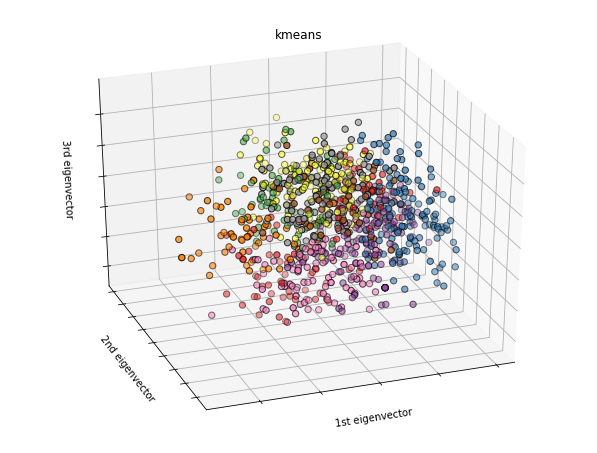

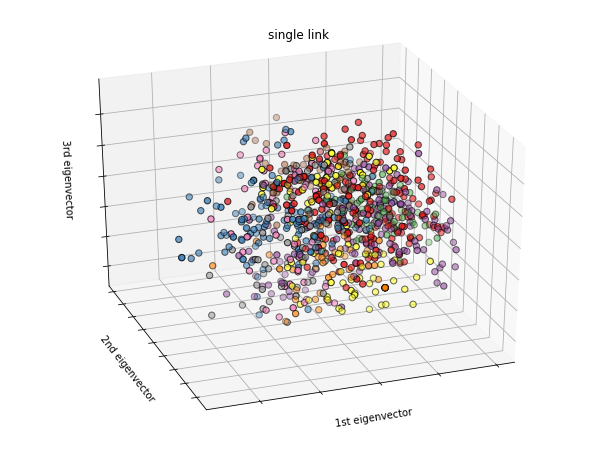

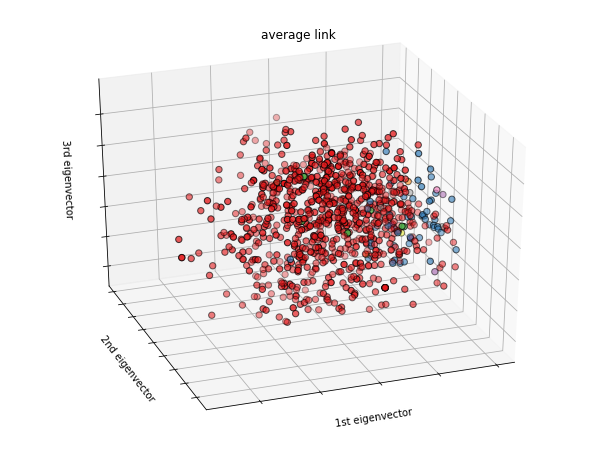

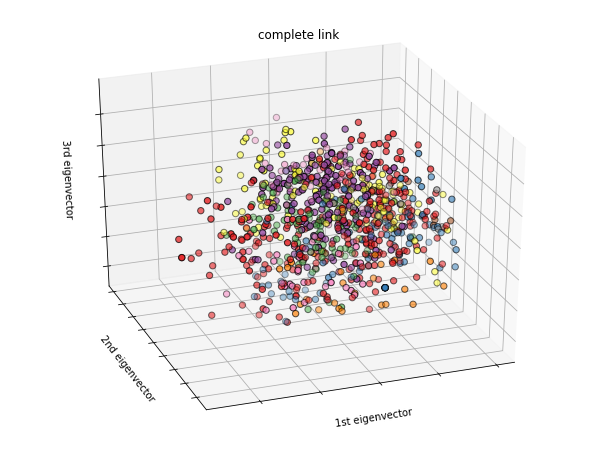

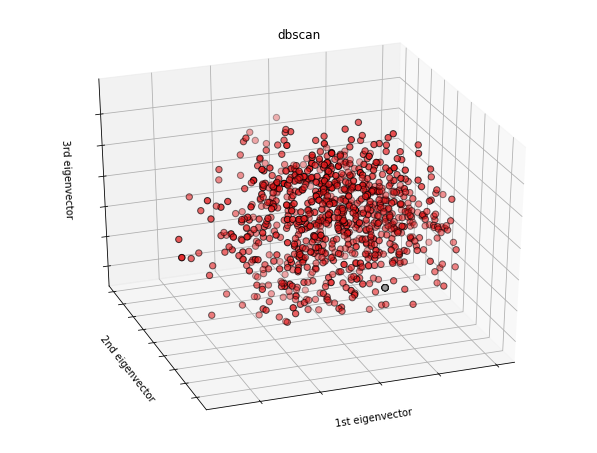

In [116]:
draw_PCA(X, all_categories_labels_kmeans, 'kmeans')
draw_PCA(X, all_categories_labels_single, 'single link')
draw_PCA(X, all_categories_labels_average, 'average link')
draw_PCA(X, all_categories_labels_complete, 'complete link')
draw_PCA(X, all_categories_labels_dbscam, 'dbscan')

# Evaluation

In [122]:
df_cat = pd.DataFrame(all_categories_labels_kmeans, index=all_categories, columns=['label'])
for i in range(len(set(all_categories_labels_kmeans))):
    cats = list(df_cat[df_cat['label'] == i].index)    
    print("cluster " + str(i) + ": ")
    print(list(cats))
    print("=============================================")
    print("=============================================")


cluster 0: 
['Sticker', 'Laptop', 'Button', 'Patch', 'Full Zip', 'Pin', 'Magic', 'Print', 'Mug', 'Paper', 'Tablet', 'Camera', 'Headphones', 'Block', 'Pad', 'Case', 'Gadget', 'Poster', 'Tape', 'Box', 'Clock', 'Telephone', 'iPad', 'Mini', 'Screen Protectors', 'Blu-Ray', 'Notebook', 'Pinback Button', 'Tag', 'Standard']
cluster 1: 
['Track & Sweat Suits', 'Plate', 'Full-Length', 'Straight, Pencil', 'Feet', 'V-Neck', 'Ring', 'Golf Balls', 'Tops & T-Shirts', 'Three Button', 'Tank', 'Slim, Skinny', 'Change Purse', 'Button-Front', 'Scoop Neck', 'Training Pants', 'Loafers & Slip-Ons', 'Top & T-shirts', 'T-Shirts', 'Track Jacket', 'Leg Warmers', 'Clutch', 'Two Button', 'Cuff Links', 'Cross Stitch', 'Knit Top', 'Button Down Shirt', 'Rings', 'Boot Cut', 'Full Skirt', 'Belt', 'Above Knee, Mini', 'Backpack Style', 'Straight Leg', 'Track & Sweat Pants', 'Dress - Flat Front', 'Mid-Calf', 'Wrap', 'Wide Leg', 'Board Shorts', 'Classic, Straight Leg', 'Knee-Length', 'Shoulder Bag', 'Hip Bag', 'T-shirts', 

In [123]:
df_cat = pd.DataFrame(all_categories_labels_single, index=all_categories, columns=['label'])
for i in range(len(set(all_categories_labels_kmeans))):
    cats = list(df_cat[df_cat['label'] == i].index)    
    print("cluster " + str(i) + ": ")
    print(sorted(list(cats)))
    print("=============================================")
    print("=============================================")

cluster 0: 
['Batteries', 'Bicycle Child Seats & Trailers', 'Cables & Adapters', 'Camera', 'Camera & Photo Accessories', 'Cameras & Photography', 'Car', 'Car Care', 'Car Electronics & Accessories', 'Car Seats', 'Car Seats & Accessories', 'Car Security & Convenience', 'Car Speakers & Systems', 'Car Stereos & Components', 'Car Subwoofers', 'Cell Phone Accessories', 'Cell Phones & Accessories', 'Cell Phones & Smartphones', 'Computers & Tablets', 'Digital Cameras', 'Flashes & Flash Accessories', 'Highchairs & Booster Seats', 'Home Speakers & Subwoofers', 'Ink & Toner', 'Laptop', 'Laptops & Netbooks', 'Lenses & Filters', 'Mini', 'Notebook', 'Pad', 'Performance Parts & Accessories', 'Portable Audio & Accessories', 'RV Parts & Accessories', 'Replacement Parts', 'Replacement Parts & Tools', 'Tablet', 'iPad']
cluster 1: 
['Activity Centers & Entertainers', 'Automotive', 'Automotive Enthusiast Merchandise', 'Basic Supplies', 'Components & Parts', 'Educational', 'Electrical Safety', 'Electronic',